In [ ]:
!gdown https://drive.google.com/u/2/uc?id=1vn8Uy4IZrnuK-Dok6iFoqP3D5VeSXD_h&export=download

Downloading...
From: https://drive.google.com/u/2/uc?id=1vn8Uy4IZrnuK-Dok6iFoqP3D5VeSXD_h
To: /content/archive (3).zip
100% 1.74G/1.74G [00:11<00:00, 149MB/s] 


In [ ]:
!unzip --qq archive\ \(3\).zip

replace ODIR-5K/ODIR-5K/Testing Images/1000_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import plotly.offline as pyo
pyo.init_notebook_mode()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
import random
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
!pip install visualkeras

In [ ]:
!unzip --qq full_df.csv.zip

In [ ]:
def dataframe_creation():
    df4 = pd.read_csv('/content/full_df.csv')
    df4['filename']='/content/preprocessed_images/'+df4['filename']
    df4['Left-Fundus']='/content/preprocessed_images/'+df4['Left-Fundus']
    df4['Right-Fundus']='/content/preprocessed_images/'+df4['Right-Fundus']
    df4['Line'] = df4['Left-Diagnostic Keywords']+' | '+df4['Right-Diagnostic Keywords']
    df4 = df4.drop(['filepath','target'], axis=1)
    return df4
df = dataframe_creation()
print(df.shape)
df.head()

(6392, 18)


ID  ...                                               Line
0   0  ...                           cataract | normal fundus
1   1  ...                      normal fundus | normal fundus
2   2  ...  laser spot，moderate non proliferative retinopa...
3   4  ...  macular epiretinal membrane | mild nonprolifer...
4   5  ...  moderate non proliferative retinopathy | moder...

[5 rows x 18 columns]

In [ ]:
df['Patient Sex'].unique()

array(['Female', 'Male'], dtype=object)

# Visualize Data

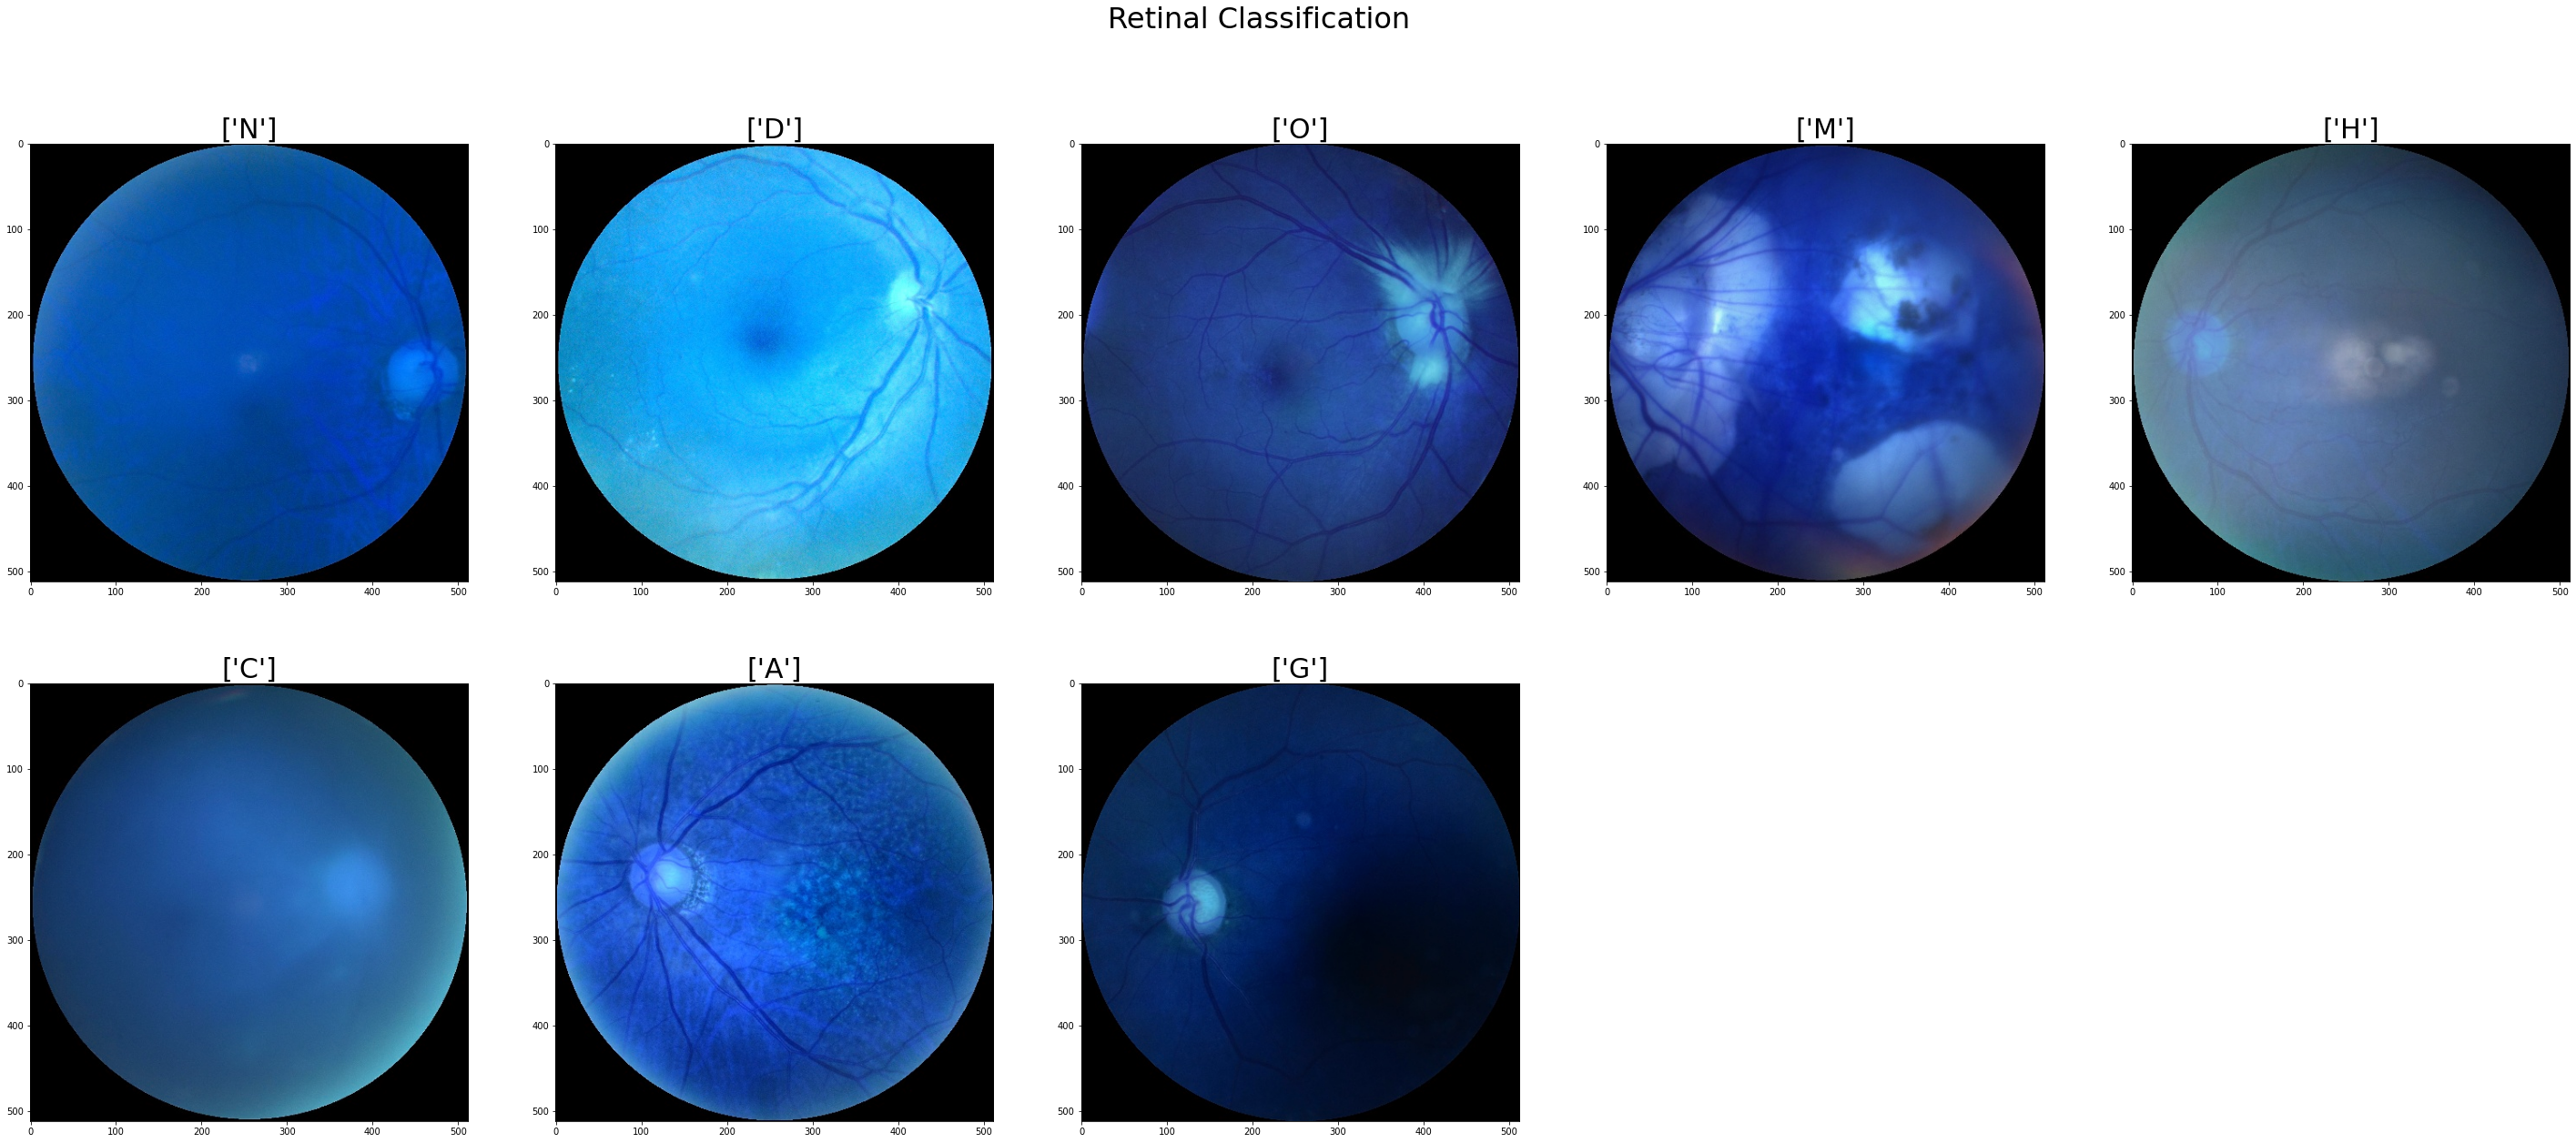

In [ ]:
count = 1
f = plt.figure(figsize=(50,20))
for Class in df['labels'].unique():
    seg = df[df['labels']==Class]
    address = seg.sample().iloc[0]['filename']
    img = cv2.imread(address)
    #print(img)
    ax = f.add_subplot(2, 5,count)
    ax = plt.imshow(img)
    ax = plt.title(Class,fontsize= 30)
    count = count + 1
plt.suptitle("Retinal Classification", size = 32)
plt.show()

In [ ]:
w , h= 16,16
final_class = 8

In [ ]:
listImg = os.listdir('/content/preprocessed_images')
string = '/content/preprocessed_images/'
list2 = list(map(lambda orig_string: string + orig_string , listImg))
indexify =[]
for i in df.index:
    if df.iloc[i]['Left-Fundus'] in list2 and df.iloc[i]['Right-Fundus'] in list2:
        continue
    else:
        indexify.append(i)

In [ ]:
print(df.shape)
df = df.drop(indexify)
print(df.shape)

(6392, 18)
(6068, 18)


In [ ]:
from tqdm import tqdm
left = []
for location in tqdm(df.iloc[:]['Left-Fundus']):
    img = cv2.imread(location,0)
    img = cv2.resize(img, (w,h), interpolation = cv2.INTER_AREA)
    img = img.reshape(w,h,1)
    left.append(img)
right = []
for location in tqdm(df.iloc[:]['Right-Fundus']):
    img = cv2.imread(location,0)
    img = cv2.resize(img, (w,h), interpolation = cv2.INTER_AREA)
    img = img.reshape(w,h,1)
    right.append(img)
X1 = np.array(left)
X2 = np.array(right)

100%|██████████| 6068/6068 [00:13<00:00, 450.12it/s]


In [ ]:
from sklearn.preprocessing import OneHotEncoder
y = np.array(df.iloc[:][['N','D','G','C','A','H','M','O']])
y = np.array(y)
print('Label :   '+str(y.shape))

Label :   (6068, 8)


In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten , Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
def model_b():
    inp1 = Input(shape=(X1.shape[1],X1.shape[2],1,))
    inp2 = Input(shape=(X2.shape[1],X2.shape[2],1,))
    new_input = Input(shape=(X1.shape[1],X1.shape[2], 3))
    conv1 = Conv2D(3, kernel_size=3, padding ='same', activation='relu')(inp1)
    i1 = tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_tensor=new_input,
                        input_shape=None,
                         pooling='avg',
                    )(conv1)
    conv2= Conv2D(3, kernel_size=3, padding ='same', activation='relu')(inp2)
    i2 = tf.keras.applications.ResNet50V2(include_top=False,weights="imagenet",input_tensor=new_input,
                        input_shape=None,
                         pooling='avg',
                    
                    )(conv2)
    merge = concatenate([i1,i2])
    class1 = Dense(1024, activation='relu')(merge)
    class1 = Dense(512, activation='relu')(class1)
    class1 = Dense(256, activation='relu')(class1)
    class1 = Dense(128, activation='relu')(class1)
    class1 = Dense(64, activation='relu')(class1)
    output = Dense(final_class, activation='sigmoid')(class1)
    model = Model(inputs=[inp1,inp2], outputs=output)
    return model
md = model_b()

94683136/94668760 [==============================] - 1s 0us/step


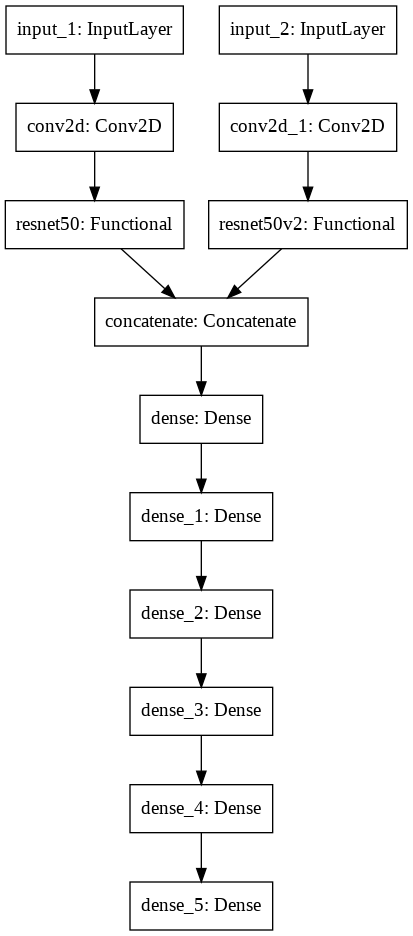

In [ ]:
plot_model(md, to_file='Hybrid_neural_network.png')

# Train Test Splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(X1,X2, y, test_size=0.20, random_state=42)

In [ ]:
X_train1, X_valid1, X_train2, X_valid2, y_train, y_valid = train_test_split(X_train1,X_train2, y_train, test_size=0.20, random_state=42)

In [25]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
def LR_verify():
        model = model_b()
        METRICS = [
                'accuracy'
        ]  
        model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=METRICS
            )
        history = model.fit([X1,X2], y, epochs=100,verbose=1,shuffle = True, validation_data=([X_valid1,X_valid2],y_valid))
        return model,history
model,history= LR_verify()

Epoch 1/100
190/190 [==============================] - 94s 492ms/step - loss: 0.3746 - accuracy: 0.3385 - val_loss: 2.7026 - val_accuracy: 0.4058
Epoch 2/100
190/190 [==============================] - 95s 499ms/step - loss: 0.3565 - accuracy: 0.3642 - val_loss: 0.4506 - val_accuracy: 0.3306
Epoch 3/100
190/190 [==============================] - 94s 493ms/step - loss: 0.3551 - accuracy: 0.3698 - val_loss: 0.9076 - val_accuracy: 0.3347
Epoch 4/100
190/190 [==============================] - 92s 486ms/step - loss: 0.3546 - accuracy: 0.3663 - val_loss: 3.9762 - val_accuracy: 0.3471
Epoch 5/100
190/190 [==============================] - 91s 480ms/step - loss: 0.3501 - accuracy: 0.3812 - val_loss: 0.7093 - val_accuracy: 0.3862
Epoch 6/100
190/190 [==============================] - 93s 490ms/step - loss: 0.3523 - accuracy: 0.3690 - val_loss: 0.4317 - val_accuracy: 0.4181
Epoch 7/100
190/190 [==============================] - 96s 507ms/step - loss: 0.3485 - accuracy: 0.3896 - val_loss: 0.3407 -

In [26]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
name = 'ODIR_ResNet'
with open(name+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(name+".h5")
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv(name+'.csv',index = False)
hist_df.tail()

loss  accuracy  val_loss  val_accuracy
95  0.267622  0.575148  0.251333      0.619979
96  0.258602  0.590804  0.242540      0.631308
97  0.258353  0.590969  0.446699      0.404737
98  0.267118  0.571028  0.361191      0.572606
99  0.250615  0.597231  0.260341      0.662204

In [27]:
json_file = open('./'+name+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./"+name+".h5")
print("Loaded model from disk")

Loaded model from disk


# Results

## Train

In [28]:
METRICS = [
                'accuracy',
                tf.keras.metrics.FalseNegatives(),
                tf.keras.metrics.FalsePositives(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.TrueNegatives(),
                tf.keras.metrics.TruePositives()
        ]  
loaded_model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=METRICS
            )
score = loaded_model.evaluate([X1,X2], y, verbose=0)

In [29]:
for i in range(len(score)):
    print(loaded_model.metrics_names[i]+" : "+str(score[i]))

loss : 0.2914089262485504
accuracy : 0.6341463327407837
false_negatives : 3732.0
false_positives : 1026.0
precision : 0.7608391642570496
recall : 0.4665523171424866
true_negatives : 40522.0
true_positives : 3264.0


## Validation

In [30]:
METRICS = [
                'accuracy',
                tf.keras.metrics.FalseNegatives(),
                tf.keras.metrics.FalsePositives(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.TrueNegatives(),
                tf.keras.metrics.TruePositives()
        ]  
loaded_model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=METRICS
            )
score = loaded_model.evaluate([X_valid1,X_valid2], y_valid, verbose=0)

In [31]:
for i in range(len(score)):
    print(loaded_model.metrics_names[i]+" : "+str(score[i]))

loss : 0.26034098863601685
accuracy : 0.6622039079666138
false_negatives_1 : 582.0
false_positives_1 : 143.0
precision_1 : 0.7927536368370056
recall_1 : 0.4844995439052582
true_negatives_1 : 6496.0
true_positives_1 : 547.0


## Test

In [32]:
METRICS = [
                'accuracy',
                tf.keras.metrics.FalseNegatives(),
                tf.keras.metrics.FalsePositives(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.TrueNegatives(),
                tf.keras.metrics.TruePositives()
        ]  
loaded_model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=METRICS
            )
score = loaded_model.evaluate([X_test1,X_test2], y_test, verbose=0)

In [33]:
for i in range(len(score)):
    print(loaded_model.metrics_names[i]+" : "+str(score[i]))

loss : 0.2875121235847473
accuracy : 0.6293245553970337
false_negatives_2 : 728.0
false_positives_2 : 215.0
precision_2 : 0.7556818127632141
recall_2 : 0.4773869216442108
true_negatives_2 : 8104.0
true_positives_2 : 665.0


In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pandas as pd
yhat = loaded_model.predict([X_test1,X_test2])
yhat = yhat.round()
report = classification_report(y_test, yhat,target_names=['N','D','G','C','A','H','M','O'],output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score  support
N              0.802198  0.542079  0.646972    404.0
D              0.744472  0.726619  0.735437    417.0
G              0.514706  0.507246  0.510949     69.0
C              0.825000  0.445946  0.578947     74.0
A              0.750000  0.236842  0.360000     76.0
H              0.600000  0.090909  0.157895     33.0
M              0.975000  0.750000  0.847826     52.0
O              0.652174  0.055970  0.103093    268.0
micro avg      0.755682  0.477387  0.585130   1393.0
macro avg      0.732944  0.419451  0.492640   1393.0
weighted avg   0.741838  0.477387  0.538721   1393.0
samples avg    0.530890  0.495332  0.505629   1393.0

In [35]:
df.to_csv('Class_Wise_Accuracy')